In [0]:
a = []
while(1):
  a.append(234324325623634)

In [0]:
import tensorflow
tensorflow.__version__

'1.15.0'

In [1]:
import os
import numpy as np
from tqdm import tqdm_notebook
import cv2
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.applications import ResNet50V2,NASNetMobile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
os.chdir("/content/drive/My Drive/")
DATA_PATH = "Data/300VW/"


# CONSTANT
WIDTH = 320
HEIGHT = 180
NUM_AXIS = 2
NUM_ANNOT = 68

In [0]:
images_tensor =  np.load(DATA_PATH + "images_tensor.npy")
targets_mat = np.load(DATA_PATH + "targets_mat.npy")
# Flatten targets
targets_mat = targets_mat.reshape(targets_mat.shape[0],-1)

In [0]:
images_feature_mat = np.load(DATA_PATH + "images_feature_mat_hog.npy")

In [0]:
images_feature_mat.shape

(14511, 6080)

In [0]:
idx = 11890
images_tensor_train,images_tensor_test = images_tensor[:idx],images_tensor[idx:]
targets_mat_train,targets_mat_test = targets_mat[:idx],targets_mat[idx:]
images_feature_mat_train,images_feature_mat_test = images_feature_mat[:idx],images_feature_mat[idx:]

NameError: ignored

In [0]:
np.shape(images_feature_mat)

(14511, 6080)

In [0]:

class MultiRegressor:
  def createModel(self,output_size):
    regressor = Sequential()
    regressor.add(Dense(output_size))
    regressor.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])
    return regressor
    
  def __init__(self,output_size,num_regressors=5):
    self.output_size = output_size
    self.num_regressors = num_regressors
    self.regressors_bank = []
    self.scaler_obj = MinMaxScaler()
    self.initialized_mat = None
    self.regressors_weight = []
    self.output_size = output_size
    self.mode = "train" 
    # To store weight if loaded pretrained model
    self.W = []
    self.b = []
    # "train" for model train from scratch
    # "pretrained" for load pretrained model
    
      
  def predict(self,X):
    num_data = X.shape[0]

    last_init_mat = None
    last_predict = None
    last_shifting_mat = None
    initialized_mat = None
    shifting_pred = None
    # to cache X,Y for last model
    X_ = None

    if self.mode == "train":  
      for idx,regressor in enumerate(self.regressors_bank):

        # if its the first regressors then random initialized
        if idx == 0:
          # initialize landmark by the mean of all landmarks
          initialized_vector= self.initialized_vector
          
          # Give initialized prediction for landmarks
          initialized_mat = np.ones((num_data,self.output_size))*initialized_vector

        else:
          # Get the last model
          # Get the last model
          last_model = self.regressors_bank[idx-1]

          last_shifting_pred = last_model.predict(X_)

          # this is shifting pred from last regressor
          initialized_mat = initialized_mat + shifting_pred 
        
        # Scale the initialized point
        if self.mode == "train":
          initialized_mat_scaled = self.scaler_obj.transform(initialized_mat)
        elif self.mode =="pretrained":
          initialized_mat_scaled = (initialized_mat - self.data_min)/(self.data_max-self.data_min)

        # Get input data to k-th regressor
        X_ = np.concatenate((X,initialized_mat_scaled),axis=1)
        shifting_pred = regressor.predict(X_)
        
    elif self.mode == "pretrained":
      for idx in range(self.num_regressors):

        # if its the first regressors then random initialized
        if idx == 0:
          # initialize landmark by the mean of all landmarks
          initialized_vector= self.initialized_vector
          
          # Give initialized prediction for landmarks
          initialized_mat = np.ones((num_data,self.output_size))*initialized_vector

        else:
          # Get the last model
          # Get the last model
          # last_model = self.regressors_bank[idx-1]

          # last_shifting_pred = last_model.predict(X_)

          # this is shifting pred from last regressor
          initialized_mat = initialized_mat + shifting_pred 
        
        # Scale the initialized point
        if self.mode == "train":
          initialized_mat_scaled = self.scaler_obj.transform(initialized_mat)
        elif self.mode =="pretrained":
          initialized_mat_scaled = (initialized_mat - self.data_min)/(self.data_max-self.data_min)

        # Get model weight
        W = self.W[idx]
        b = np.expand_dims(self.b[idx],0)
        
        # Get input data to k-th regressor
        X_ = np.concatenate((X,initialized_mat_scaled),axis=1)
        shifting_pred = X_.dot(W)+ b
        

    return initialized_mat+shifting_pred

  def fit(self,X,Y,validation_split=0.2,max_epochs=20):
    for i in range(self.num_regressors):
      new_model = self.createModel(self.output_size)
      self.regressors_bank.append(new_model)

    num_data = X.shape[0]

    # Fit the scaler
    self.scaler_obj.fit(Y)

    last_init_mat = None
    last_predict = None

    # to cache X,Y for last model
    X_ = None
    Y_ = None
    
    ES_callback = EarlyStopping(monitor='val_mean_absolute_error',patience=3,restore_best_weights=True,verbose=1)


    for idx,regressor in enumerate(self.regressors_bank):

      # if its the first regressors then random initialized
      if idx == 0:
        # initialize landmark by the mean of all landmarks
        initialized_vector= np.expand_dims(Y.mean(axis=0),axis=0)

        # Give initialized prediction for landmarks
        initialized_mat = np.ones((num_data,self.output_size))*initialized_vector
        self.initialized_vector = initialized_vector.copy()
        last_init_mat = initialized_mat

      else:
        # Get the last model
        last_model = self.regressors_bank[idx-1]

        last_shifting_pred = last_model.predict(X_)

        initialized_mat = initialized_mat + last_shifting_pred

      shifting_mat = Y - initialized_mat
      initialized_mat_scaled = self.scaler_obj.transform(initialized_mat)

      # Training and target data for current regressor
      X_ = np.concatenate((X,initialized_mat_scaled),axis=1)
      Y_ = shifting_mat
      
      regressor.fit(X_,Y_,epochs=max_epochs,callbacks=[ES_callback],validation_split=validation_split)
  
  def save_regressors(self,path):

    # Save min max for scaler
    data_min = np.expand_dims(MR.scaler_obj.data_min_,0)
    data_max = np.expand_dims(MR.scaler_obj.data_max_,0)
    np.save(path + "data_min.npy",data_min)
    np.save(path + "data_max.npy",data_max)

    # Save initialized mat
    np.save(path + "init_vector.npy",self.initialized_vector)

    # Save weights
    for idx,regressor in enumerate(self.regressors_bank):
      W = regressor.layers[0].get_weights()[0]
      b = regressor.layers[0].get_weights()[1]
      np.save(path + "W" + str(idx) + ".npy",W)
      np.save(path + "b" + str(idx) + ".npy",b)
    print("model saved to " + path)

  def load_regressors(self,path):
    # Set mode to "pretrained"
    self.mode = "pretrained"

    # Load pretrained scaler attribute
    self.data_min = np.load(path + "data_min.npy")
    self.data_max = np.load(path + "data_max.npy")

    # Save initialized mat
    self.initialized_vector = np.load(path + "init_vector.npy")

    for idx in range (self.num_regressors):
      self.W.append(np.load(path + "W" +str(idx)+".npy"))
      self.b.append(np.load(path + "b" +str(idx)+".npy"))
    print("model loaded from" + path)


In [0]:
MR.scaler_obj.data_min_.shape

NameError: ignored

In [0]:
indices = np.arange(targets_mat.shape[0])
np.random.shuffle(indices)
images_feature_mat_ = images_feature_mat[indices].copy()
targets_mat_ = targets_mat[indices].copy()

In [0]:
MR = MultiRegressor(output_size = 136,num_regressors=7)
# MR.fit(images_feature_mat_,targets_mat_,validation_split=0.1806,max_epochs=100)

In [25]:
MR.regressors_bank[0].layers[0].get_weights()[1].shape

(136,)

In [56]:
MR.save_regressors(DATA_PATH + "Pretrained-SDM/")

model saved to Data/300VW/Pretrained-SDM/


In [63]:
MR.load_regressors(DATA_PATH + "Pretrained-SDM/")

model loaded fromData/300VW/Pretrained-SDM/


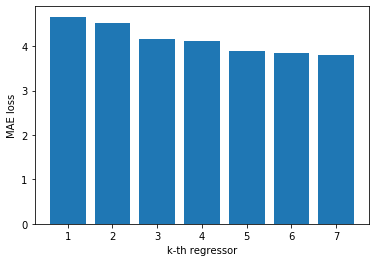

In [0]:
import matplotlib.pyplot as plt

loss = [4.6628,4.5288,4.1647,4.1226,3.8939,3.8398,3.7994]
k = [1,2,3,4,5,6,7]
plt.bar(k,loss)
plt.xlabel("k-th regressor")
plt.ylabel("MAE loss")
plt.savefig('foo.png')


In [0]:
MR.load_regressors(DATA_PATH + "Pretrained-SDM/")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
model loaded fromData/300VW/Pretrained-SDM/


In [0]:
np.load("/content/regressors/init_mat.npy", allow_pickle=True)

array(None, dtype=object)

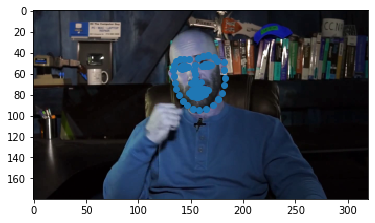

In [67]:
idx = 1231
y = MR.predict(np.expand_dims(images_feature_mat[idx],0))
y = y.reshape(68,2)
import matplotlib.pyplot as plt
plt.imshow(images_tensor[idx])
plt.scatter(y[:,0],y[:,1])

In [59]:
from skimage.feature import hog
img = cv2.imread('/content/drive/My Drive/Data/300VW/images/001_frame_')
img = cv2.resize(img,(320,180))
feature,_ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), visualize=True)
y = MR.predict(np.expand_dims(feature,0))
y = y.reshape(68,2)




error: ignored

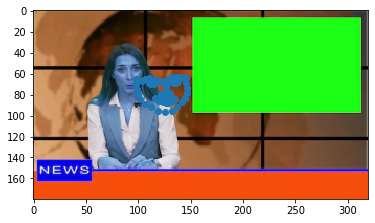

In [0]:
plt.imshow(img)
plt.scatter(y[:,0],y[:,1])

In [0]:
y.shape

(1, 136)

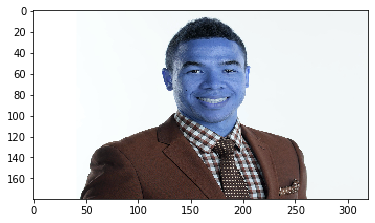

In [0]:
plt.imshow(img)

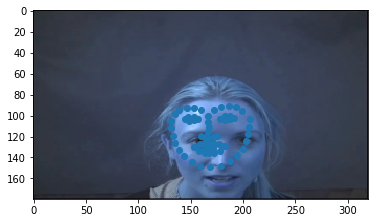

In [0]:
y = MR.predict(np.expand_dims(images_feature_mat[0],0))
y = y.reshape(68,2)
import matplotlib.pyplot as plt
plt.imshow(images_tensor[0])
plt.scatter(y[:,0],y[:,1])

In [0]:
targets_mat

array([[132.59144251, 121.95671854, 133.59498437, ..., 163.18139708,
        176.03575849, 162.7106329 ],
       [186.664     ,  48.16      , 186.70575   , ...,  66.491     ,
        200.9345    ,  66.1965    ],
       [187.81975   ,  50.726     , 188.2295    , ...,  64.9495    ,
        199.88875   ,  64.867     ],
       ...,
       [150.821     ,  50.684     , 151.39725   , ...,  67.1145    ,
        161.18325   ,  66.62925   ],
       [157.38775   ,  50.88025   , 157.876     , ...,  68.57025   ,
        167.05625   ,  68.00175   ],
       [165.92775   ,  50.83225   , 165.872     , ...,  70.6575    ,
        173.221     ,  69.79375   ]])

In [0]:
targets_mat[0]

array([132.59144251, 121.95671854, 133.59498437, 132.04334017,
       135.89564865, 141.88682504, 138.65090804, 151.15420319,
       142.83527289, 159.78910158, 149.24579417, 167.27203422,
       157.64827557, 173.51732488, 167.79488808, 178.23085508,
       179.48933145, 179.44312394, 190.59381905, 177.83217857,
       199.83179325, 172.78886708, 207.52906819, 166.26358773,
       213.39516816, 158.40685185, 217.11148614, 149.90909627,
       219.6870712 , 141.51566669, 221.9038115 , 132.98127451,
       223.08173939, 124.22936987, 140.79837695, 119.22498082,
       146.7684715 , 115.24130102, 155.09955585, 114.40245169,
       163.56712328, 115.71237949, 171.26255665, 118.31154485,
       189.49186946, 117.58099962, 197.05083027, 114.7710837 ,
       204.81062484, 113.25008477, 212.54171378, 113.49593969,
       218.19055563, 116.64729164, 180.86828657, 124.06161424,
       180.98555407, 131.1649108 , 181.13587367, 138.1762867 ,
       181.35173607, 145.2539086 , 171.67381795, 147.85

In [0]:
targets_mat

array([[132.59144251, 121.95671854, 133.59498437, ..., 163.18139708,
        176.03575849, 162.7106329 ],
       [186.664     ,  48.16      , 186.70575   , ...,  66.491     ,
        200.9345    ,  66.1965    ],
       [187.81975   ,  50.726     , 188.2295    , ...,  64.9495    ,
        199.88875   ,  64.867     ],
       ...,
       [150.821     ,  50.684     , 151.39725   , ...,  67.1145    ,
        161.18325   ,  66.62925   ],
       [157.38775   ,  50.88025   , 157.876     , ...,  68.57025   ,
        167.05625   ,  68.00175   ],
       [165.92775   ,  50.83225   , 165.872     , ...,  70.6575    ,
        173.221     ,  69.79375   ]])